# simple mathematical language model checker

In [1]:
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import random
from multiprocessing.pool import ThreadPool
import os

In [2]:
ops = ['-', '+', '/', '*', '^']
EMPTY = 'EMPTY'
NUM = 'NUM'
EQ_SIGN = '='
sl_vocabulary = ops + [EQ_SIGN, NUM, EMPTY] # has to be in this order, DO NOT TOUCH
dictionary = {el:idx for idx,el in enumerate(sl_vocabulary)}

def sl_gen_sample(length, max_vector_len):
  values = []
  for _ in range(length):
    values.append(dictionary[NUM])
    values.append(random.randint(0, len(ops)-1))
  values += [dictionary[NUM],dictionary[EQ_SIGN],dictionary[NUM]]
  filled_to_the_brim = values + [dictionary[EMPTY] for _ in range(max_vector_len - len(values))]
  return filled_to_the_brim

def sl_generate_samples(num_samples, min_len, max_len, max_vector_len):
  lens = np.random.randint(min_len, max_len, num_samples)
  return np.asarray([sl_gen_sample(l, max_vector_len) for l in lens])

def sl_decode_sample(sample):
  return [sl_vocabulary[int(v + 0.5)] for v in sample]

In [3]:
def prepare_record(parsed_file):
  parsed = np.loadtxt(parsed_file, dtype=float, converters=float)
  return parsed

def load_dataset(parsed_dir, max_size=None) -> list:
  parsed_files = sorted(os.listdir(parsed_dir))
  if max_size:
    parsed_files = parsed_files[:max_size]

  with ThreadPool() as pool:
    parsed_files = pool.map(lambda f: f"{parsed_dir}{f}", parsed_files)
    files = list(parsed_files)

  with ThreadPool() as pool:
  #   # pool.map guaranteese to preserve order
  #   # pool.map 'consumes' mapping created in previous with block
  #   # map() function returns a generator that is exhausted after is it used
    return [np.array(pool.map(lambda file: prepare_record(file), files)), files]

In [4]:
def scale_dataset_down(dataset, dic_size):
    l = lambda x: (x / (dic_size - 1))
    return np.array(list(map(l, dataset)))

In [5]:
def scale_dataset(dataframe, dic_size):
    l = lambda x: (x) * (dic_size - 1)
    return np.array(list(map(l, dataframe)))

In [6]:
def sinusoidal_embedding(x, embedding_min_frequency, embedding_max_frequency, embedding_dims):
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=1
    )
    return embeddings

In [7]:
def get_network(tokens_capacity, embedding_min_frequency, embedding_max_frequency, embedding_dims):
    noisy_images = keras.Input(shape=(tokens_capacity))
    noise_variances = keras.Input(shape=(1))

    emb = lambda x: sinusoidal_embedding(x, embedding_min_frequency, embedding_max_frequency, embedding_dims)
    e = layers.Lambda(emb)(noise_variances)

    x = layers.Dense(1024)(noisy_images)
    x = layers.Concatenate()([x, e])
    x = layers.Dense(512, name="dense01")(x)
    x = layers.Dense(1024, name="dense02", activation=keras.activations.relu)(x)
    x = layers.Dense(2048, name="dense03", activation=keras.activations.relu)(x)
    x = layers.Dense(tokens_capacity, name="last_dense")(x)

    return keras.Model([noisy_images, noise_variances], x, name="simple_net")

In [8]:

class DiffusionModel(keras.Model):
    def __init__(
      self, tokens_capacity, dictionary_size, network,
      max_signal_rate, min_signal_rate,
    ):
        super().__init__()

        self.tokens_capacity = tokens_capacity
        self.dictionary_size = dictionary_size
        self.network = network
        self.max_signal_rate = max_signal_rate
        self.min_signal_rate = min_signal_rate
        self.normalizer = layers.Normalization()

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss") # for training
        self.sample_loss_tracker = keras.metrics.Mean(name="i_loss") # for human evaluation

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.sample_loss_tracker]

    def denormalize(self, samples):
        samples = self.normalizer.mean + samples * self.normalizer.variance**0.5
        return samples

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(self.max_signal_rate)
        end_angle = tf.acos(self.min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)

        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_samples, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        network = self.network

        # predict noise component and calculate the sample component using it
        pred_noises = network([noisy_samples, noise_rates**2], training=training)
        pred_samples = (noisy_samples - noise_rates * pred_noises) / signal_rates # maybe some more sophisticated way of removing noise

        return pred_noises, pred_samples

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_samples = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy sample" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_samples = initial_noise
        for step in range(diffusion_steps):
            noisy_samples = next_noisy_samples

            # separate the current noisy sample to its components
            diffusion_times = tf.ones((num_samples)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            signal_rates = tf.expand_dims(signal_rates, axis=1)
            noise_rates = tf.expand_dims(noise_rates, axis=1)

            pred_noises, pred_samples = self.denoise(
                noisy_samples, noise_rates, signal_rates, training=False
            )
            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_signal_rates = tf.expand_dims(next_signal_rates, axis=1)
            next_noise_rates = tf.expand_dims(next_noise_rates, axis=1)
            next_noisy_samples = (
                next_signal_rates * pred_samples + next_noise_rates * pred_noises
            )
            # this new noisy sample will be used in the next step

        return pred_samples

    # generated values should be between 0 and 1, network should work better this way
    def generate(self, num_samples, diffusion_steps):
        # Generate sample from complete noise
        initial_noise = tf.random.normal(shape=(num_samples, self.tokens_capacity))
        generated_sample = self.reverse_diffusion(initial_noise, diffusion_steps)
        denormalized_generated_sample = self.denormalize(generated_sample)
        return generated_sample, tf.clip_by_value(tf.math.abs(denormalized_generated_sample), 0, 1)

In [9]:
# from samples, I deducted that cp-0511 is a little bit better model for some unknown reason
checkpoint_path = "simplest_language_model\\cp-0511\\model"

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95
    
# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
embedding_min_frequency = 1.0

# dictionary related
SIMPLE_MATH_DICTIONARY_SIZE = 8 # 246
TOKENS_CAPACITY = 128 # 2048

data_dir = f"../data/simplest_language_model/"
dataset, filenames = load_dataset(data_dir)
dataset = scale_dataset_down(dataset, SIMPLE_MATH_DICTIONARY_SIZE)
    
network = get_network(TOKENS_CAPACITY, embedding_min_frequency, embedding_max_frequency, embedding_dims)
network.summary()
print("Network created")

model = DiffusionModel(TOKENS_CAPACITY, SIMPLE_MATH_DICTIONARY_SIZE, network, max_signal_rate, min_signal_rate)
print("Model created")

model.compile(
    optimizer = keras.optimizers.experimental.AdamW(learning_rate=0, weight_decay=0),
    loss = keras.losses.mean_absolute_error
)
model.normalizer.adapt(dataset)

model.load_weights(checkpoint_path)

Model: "simple_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 1024)         132096      ['input_1[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 32)           0           ['input_2[0][0]']                
                                                                                         

In [10]:
from matplotlib import pyplot as plt

In [11]:
raw, denormalized = model.generate(5,100)

In [12]:
with np.printoptions(precision=3, floatmode='fixed'):
    for idx in range(len(denormalized)):
      print(raw[idx])
      print(denormalized[idx])
      scaled = scale_dataset(denormalized[idx], SIMPLE_MATH_DICTIONARY_SIZE)
      print(" ".join(sl_decode_sample(scaled)))

tf.Tensor(
[-0.992 -1.428 -0.738  1.680 -0.031 -2.986 -1.345 -1.414  0.275  1.560
 -0.430  0.074 -0.501 -1.368 -0.155 -0.775  0.044 -2.166 -0.251  0.101
 -0.572 -1.125 -0.383 -1.673 -0.261 -0.899 -0.266 -2.412 -0.713  2.013
  1.104  1.351  1.223  1.326  3.152  1.862  1.650  1.778  1.866  1.407
  1.354  1.500  1.770  1.453  1.635  1.639  0.903  1.431  1.180  1.058
  1.487  1.549  1.224  2.130  1.449  1.211  1.643  1.208  0.657  1.030
  1.121  0.612  0.708  0.547  0.800  0.999  0.564  1.073  0.701  1.146
  0.725  1.006  0.945  1.165  0.881  1.156  1.015  0.746  1.072  0.385
  1.046  0.929  0.862  0.525  0.145  0.853  0.653  0.481  0.760 -0.159
  0.585  0.759  0.657  0.502  0.796  0.552 -0.057  0.415  0.056  0.960
  1.030  0.662  0.205  0.622 -0.014  0.408  1.062  0.852  0.770  0.050
  0.556  0.642  0.992  0.025  0.192  0.173  0.440  0.034  0.251 -0.077
 -0.106 -0.175 -0.323 -0.505  0.055  0.014 -0.384  0.205], shape=(128,), dtype=float32)
tf.Tensor(
[0.857 0.002 0.857 0.625 0.857 0.315 0

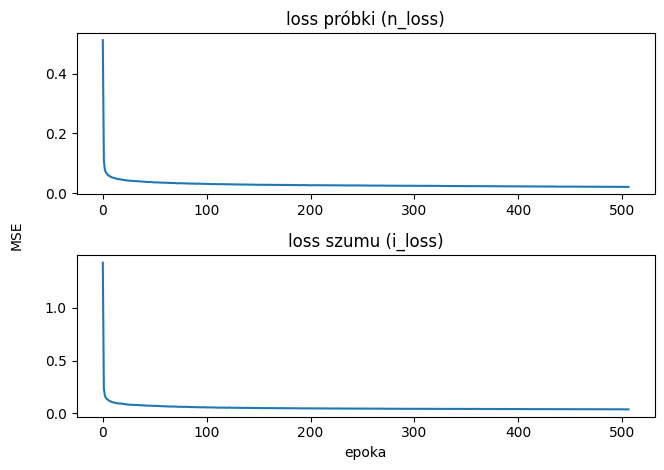

In [9]:
def plot_things(data_path):
  '''
    data will always have epoch number as its first column
  '''
  data = np.genfromtxt(data_path, dtype=float, delimiter=',', names=True)
  labels = data.dtype.names


  fig, ax = plt.subplots(len(labels) - 1, 1)
  loss_labs = ["loss próbki", "loss szumu"]
  for count, label in enumerate(labels[1:]):
    ax[count].set_title(loss_labs[count] + f" ({label})")
    ax[count].plot(data[label])

  plt.xlabel("epoka")
  # plt.ylabel("MSE")
  fig.text(-0.02, 0.5, 'MSE', ha='center', va='center', rotation='vertical')
  fig.tight_layout()
  return fig

path_to_csv ="history_c_lang.csv"
fig = plot_things(path_to_csv)